```
---
title: Enantiomers of small molecules in ChEBI
tags: smallMolecules, ChEBI, enantiomers
lang: en
version: 0.5
date: 2023-06-02
---
```

In [12]:
import importlib
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys

In [6]:
#reactomeVersion = 83 # was 81
#chebiVersion = 221 # was 219 # was 207
#endpointURL = "http://localhost:3030/reactome/query"
endpointURL = "http://localhost:3030/chebi/query"
#endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

endpointURLupdate = endpointURL.replace("/query", "/update")

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/chebi#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>


"""

In [4]:
query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?ontology ?versionIRI (REPLACE(REPLACE(STR(?versionIRI), 'http://purl.obolibrary.org/obo/chebi/', ''), '/chebi.owl', '') AS ?versionNumber)
WHERE {
  ?ontology rdf:type owl:Ontology .
  ?ontology owl:versionIRI ?versionIRI .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

chebiVersion = int(results["results"]["bindings"][0]["versionNumber"]["value"])
print("ChEBI version: {}".format(chebiVersion))

ChEBI version: 221


# 0. General structure of ChEBI

## 0.1 Number of pairs of enantiomers

In [59]:
query="""
SELECT (COUNT(*) AS ?nbEnantiomerPairs)
WHERE {
  SELECT DISTINCT ?molecule1 ?molecule2
  WHERE {
    ?molecule1 rdf:type owl:Class .
    ?molecule1 rdfs:subClassOf ?restriction .
    ?restriction rdf:type owl:Restriction .
    ?restriction owl:onProperty chebirel:is_enantiomer_of .
    ?restriction owl:someValuesFrom ?molecule2 .
    #FILTER (str(?molecule1) < str(?molecule2))
  }
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

nbEnantiomerPairs = int(results["results"]["bindings"][0]["nbEnantiomerPairs"]["value"])
print("Nb enantiomer pairs: {}".format(nbEnantiomerPairs))

Nb enantiomer pairs: 2718


## 0.2 Number of molecules having at least 1 enantiomer

In [60]:
query="""
SELECT (COUNT(DISTINCT ?molecule1) AS ?nbEnantiomerMolecules)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  #FILTER (str(?molecule1) < str(?molecule2))
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

nbEnantiomerMolecules = int(results["results"]["bindings"][0]["nbEnantiomerMolecules"]["value"])
print("Nb nbEnantiomerMolecules: {}".format(nbEnantiomerMolecules))

Nb nbEnantiomerMolecules: 2718


In [7]:
query="""
SELECT (COUNT(DISTINCT ?molecule2) AS ?nbEnantiomerMolecules)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  #FILTER (str(?molecule1) < str(?molecule2))
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

nbEnantiomerMolecules = int(results["results"]["bindings"][0]["nbEnantiomerMolecules"]["value"])
print("Nb nbEnantiomerMolecules: {}".format(nbEnantiomerMolecules))

Nb nbEnantiomerMolecules: 2718


In [8]:
query="""
# Nb of enantiomers associated to a molecule

SELECT ?molecule1 ?molecule1Label (COUNT(DISTINCT ?molecule2) AS ?nbEnantiomers)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  #FILTER (str(?molecule1) < str(?molecule2))
}
GROUP BY ?molecule1 ?molecule1Label
ORDER BY DESC(?nbEnantiomers)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbEnantiomers'] = pandas.to_numeric(df['nbEnantiomers'])
df

molecule1  \
0        http://purl.obolibrary.org/obo/CHEBI_100   
1     http://purl.obolibrary.org/obo/CHEBI_100462   
2      http://purl.obolibrary.org/obo/CHEBI_10115   
3     http://purl.obolibrary.org/obo/CHEBI_101278   
4     http://purl.obolibrary.org/obo/CHEBI_102030   
...                                           ...   
2713    http://purl.obolibrary.org/obo/CHEBI_9578   
2714    http://purl.obolibrary.org/obo/CHEBI_9599   
2715      http://purl.obolibrary.org/obo/CHEBI_98   
2716      http://purl.obolibrary.org/obo/CHEBI_99   
2717    http://purl.obolibrary.org/obo/CHEBI_9955   

                                         molecule1Label  nbEnantiomers  
0                                        (-)-medicarpin              1  
1     (S)-1,2-di-O-dodecanylglycero-3-glutaric acid ...              1  
2                                           zingiberene              1  
3                                             diltiazem              1  
4                                        (R)-talarozole              1  
...                                                 ...            ...  
2713                                     (-)-thujopsene              1  
2714                            (S)-timolol (anhydrous)              1  
2715                                       (S)-linalool              1  
2716                                      (-)-maackiain              1  
2717                                  (R)-(+)-verbenone              1  

[2718 rows x 3 columns]

In [9]:
query="""
# Nb of molecules pointing to an enantiomer

SELECT ?molecule2 ?molecule2Label (COUNT(DISTINCT ?molecule1) AS ?nbEnantiomers)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule2 rdfs:label ?molecule2Label . }
  #FILTER (str(?molecule1) < str(?molecule2))
}
GROUP BY ?molecule2 ?molecule2Label
ORDER BY DESC(?nbEnantiomers)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbEnantiomers'] = pandas.to_numeric(df['nbEnantiomers'])
df

molecule2  \
0        http://purl.obolibrary.org/obo/CHEBI_100   
1     http://purl.obolibrary.org/obo/CHEBI_100462   
2      http://purl.obolibrary.org/obo/CHEBI_10115   
3     http://purl.obolibrary.org/obo/CHEBI_101278   
4     http://purl.obolibrary.org/obo/CHEBI_102030   
...                                           ...   
2713    http://purl.obolibrary.org/obo/CHEBI_9578   
2714    http://purl.obolibrary.org/obo/CHEBI_9599   
2715      http://purl.obolibrary.org/obo/CHEBI_98   
2716      http://purl.obolibrary.org/obo/CHEBI_99   
2717    http://purl.obolibrary.org/obo/CHEBI_9955   

                                         molecule2Label  nbEnantiomers  
0                                        (-)-medicarpin              1  
1     (S)-1,2-di-O-dodecanylglycero-3-glutaric acid ...              1  
2                                           zingiberene              1  
3                                             diltiazem              1  
4                                        (R)-talarozole              1  
...                                                 ...            ...  
2713                                     (-)-thujopsene              1  
2714                            (S)-timolol (anhydrous)              1  
2715                                       (S)-linalool              1  
2716                                      (-)-maackiain              1  
2717                                  (R)-(+)-verbenone              1  

[2718 rows x 3 columns]

> **Interpretation:** Each molecule having an enantiomer has exactly 1 enantiomer and conversely

In [61]:
query="""
SELECT DISTINCT ?molecule1 ?molecule2
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  #FILTER (str(?molecule1) < str(?molecule2))
  
  FILTER NOT EXISTS {
    ?molecule2 rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule1 .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

Empty DataFrame
Columns: [molecule1, molecule2]
Index: []

> **Interpretation:** the `is_enentiomer_of` relation is symmetric

## 0.3 Number of descendants of the molecules having at least 1 enantiomer

In [62]:
query="""
SELECT ?molecule1 ?molecule1Label (COUNT(DISTINCT ?enantiomerSubClass) AS ?nbEnantiomerSubclasses)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  ?enantiomerSubClass rdfs:subClassOf* ?molecule1 .
  ?enantiomerSubClass rdf:type owl:Class .
}
GROUP BY ?molecule1 ?molecule1Label
ORDER BY DESC(?nbEnantiomerSubclasses)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbEnantiomerSubclasses'] = pandas.to_numeric(df['nbEnantiomerSubclasses'])
df

molecule1  \
0     http://purl.obolibrary.org/obo/CHEBI_21644   
1     http://purl.obolibrary.org/obo/CHEBI_52639   
2     http://purl.obolibrary.org/obo/CHEBI_21545   
3     http://purl.obolibrary.org/obo/CHEBI_17375   
4     http://purl.obolibrary.org/obo/CHEBI_15778   
...                                          ...   
2713   http://purl.obolibrary.org/obo/CHEBI_9578   
2714   http://purl.obolibrary.org/obo/CHEBI_9599   
2715     http://purl.obolibrary.org/obo/CHEBI_98   
2716     http://purl.obolibrary.org/obo/CHEBI_99   
2717   http://purl.obolibrary.org/obo/CHEBI_9955   

                          molecule1Label  nbEnantiomerSubclasses  
0                    N-acyl-L-amino acid                     182  
1                      N-acylsphingosine                      59  
2                  N-acetyl-L-amino acid                      36  
3     (2S)-2-hydroxy monocarboxylic acid                      17  
4                    N-acyl-D-amino acid                      14  
...                                  ...                     ...  
2713                      (-)-thujopsene                       1  
2714             (S)-timolol (anhydrous)                       1  
2715                        (S)-linalool                       1  
2716                       (-)-maackiain                       1  
2717                   (R)-(+)-verbenone                       1  

[2718 rows x 3 columns]

Text(0, 0.5, 'nb of enantiomers')

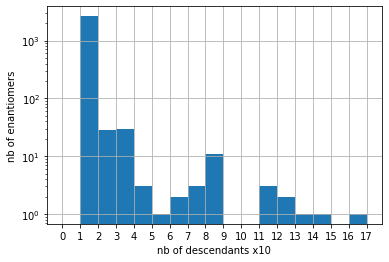

In [12]:
nbMappingsMax = df['nbEnantiomerSubclasses'].max()
ax = df['nbEnantiomerSubclasses'].hist(bins=range(int((nbMappingsMax+2)/10)), log=True)
ax.set_xticks(range(int((nbMappingsMax+2)/10)))
ax.set_xlabel("nb of descendants x10")
ax.set_ylabel("nb of enantiomers")

> **Interpretation:** most enantiomers have few (<10) descendants

In [63]:
query="""
SELECT (COUNT(DISTINCT ?enantiomerSubClass) AS ?nbEnantiomerSubclasses)
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  #OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  ?enantiomerSubClass rdfs:subClassOf+ ?molecule1 .
  ?enantiomerSubClass rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbEnantiomerSubclasses'] = pandas.to_numeric(df['nbEnantiomerSubclasses'])
df

nbEnantiomerSubclasses
0                     485

> **Interpretation:** There are 485 descendants of enantiomers. Some of these 485 may be enantiomers themselves

In [14]:
query="""
SELECT DISTINCT ?molecule1 ?molecule1Label
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  FILTER NOT EXISTS {
    ?molecule1 rdfs:subClassOf+ ?enantiomerSuperClass .
    ?enantiomerSuperClass rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule3 .
    
  }
}
ORDER BY ?molecule1
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1  \
0        http://purl.obolibrary.org/obo/CHEBI_100   
1     http://purl.obolibrary.org/obo/CHEBI_100462   
2      http://purl.obolibrary.org/obo/CHEBI_10115   
3     http://purl.obolibrary.org/obo/CHEBI_101278   
4     http://purl.obolibrary.org/obo/CHEBI_102030   
...                                           ...   
2593    http://purl.obolibrary.org/obo/CHEBI_9578   
2594    http://purl.obolibrary.org/obo/CHEBI_9599   
2595      http://purl.obolibrary.org/obo/CHEBI_98   
2596      http://purl.obolibrary.org/obo/CHEBI_99   
2597    http://purl.obolibrary.org/obo/CHEBI_9955   

                                         molecule1Label  
0                                        (-)-medicarpin  
1     (S)-1,2-di-O-dodecanylglycero-3-glutaric acid ...  
2                                           zingiberene  
3                                             diltiazem  
4                                        (R)-talarozole  
...                                                 ...  
2593                                     (-)-thujopsene  
2594                            (S)-timolol (anhydrous)  
2595                                       (S)-linalool  
2596                                      (-)-maackiain  
2597                                  (R)-(+)-verbenone  

[2598 rows x 2 columns]

> **Interpretation:** Among the 2718 enantiomers, 2598 do not have an ancestor that also has an enantiomer. 2718-2598=120 enantiomers are descendants of at least another enantiomer.

In [15]:
query="""
SELECT DISTINCT ?molecule1 ?molecule1Label
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  #FILTER NOT EXISTS {
    ?molecule1 rdfs:subClassOf+ ?enantiomerSuperClass .
    ?enantiomerSuperClass rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule3 .
    
  #}
}
ORDER BY ?molecule1
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1  \
0    http://purl.obolibrary.org/obo/CHEBI_10295   
1    http://purl.obolibrary.org/obo/CHEBI_10696   
2    http://purl.obolibrary.org/obo/CHEBI_11009   
3    http://purl.obolibrary.org/obo/CHEBI_13022   
4    http://purl.obolibrary.org/obo/CHEBI_13172   
..                                          ...   
115  http://purl.obolibrary.org/obo/CHEBI_85637   
116  http://purl.obolibrary.org/obo/CHEBI_85937   
117  http://purl.obolibrary.org/obo/CHEBI_86061   
118  http://purl.obolibrary.org/obo/CHEBI_90086   
119  http://purl.obolibrary.org/obo/CHEBI_90412   

                       molecule1Label  
0               alpha-L-sorbopyranose  
1      (3S)-3-hydroxy-L-aspartic acid  
2                 (R)-3-phenyllactate  
3                      keto-D-sorbose  
4                      keto-L-sorbose  
..                                ...  
115      (2S)-2-hydroxytetradecanoate  
116  (2S)-2-hydroxytetradecanoic acid  
117                     L-idopyranose  
118              N-benzoyl-L-arginine  
119         N-benzoyl-L-phenylalanine  

[120 rows x 2 columns]

![enantiomer relationships among the subclasses of "L-idose" (`chebidb:86060`) and "D-idose" (`chebidb:28014`). Note that each subclass only has an enantiomer.](figures/chebi-enantiomer-idose.png)

> Enantiomer relationships among the subclasses of "L-idose" (`chebidb:86060`) and "D-idose" (`chebidb:28014`). Note that each subclass only has an enantiomer

## 0.4 Strategies

### 0.4.1 descendants of the union of the molecule and its enantiomer

### 0.4.2 union of the descendants of the molecule and of the descendants of its enantiomer

In [64]:
query="""
SELECT (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule2 .
      ?descendant rdf:type owl:Class .
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbEnantiomerDescendants
0                    3083

In [66]:
query="""
SELECT ?molecule1 (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule2 .
      ?descendant rdf:type owl:Class .
    }
  }
}
GROUP BY ?molecule1
ORDER BY DESC(?nbEnantiomerDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1 nbEnantiomerDescendants
0     http://purl.obolibrary.org/obo/CHEBI_15778                     196
1     http://purl.obolibrary.org/obo/CHEBI_21644                     196
2     http://purl.obolibrary.org/obo/CHEBI_52639                      60
3     http://purl.obolibrary.org/obo/CHEBI_83223                      60
4     http://purl.obolibrary.org/obo/CHEBI_21501                      43
...                                          ...                     ...
2713   http://purl.obolibrary.org/obo/CHEBI_9578                       2
2714   http://purl.obolibrary.org/obo/CHEBI_9599                       2
2715     http://purl.obolibrary.org/obo/CHEBI_98                       2
2716     http://purl.obolibrary.org/obo/CHEBI_99                       2
2717   http://purl.obolibrary.org/obo/CHEBI_9955                       2

[2718 rows x 2 columns]

### 0.4.3 transitive closure of the subClassOf and enantiomer relations

### 0.4.4 union of the descendants of the molecule and of the enantiomers of the descendants of the molecule

In [65]:
query="""
SELECT (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      
      ?subMolecule rdfs:subClassOf* ?molecule1 .
      ?subMolecule rdfs:subClassOf ?restriction2 .
      ?restriction2 rdf:type owl:Restriction .
      ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
      ?restriction2 owl:someValuesFrom ?descendant .
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbEnantiomerDescendants
0                    3083

In [68]:
query="""
SELECT ?molecule1 (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      
      ?subMolecule rdfs:subClassOf* ?molecule1 .
      ?subMolecule rdfs:subClassOf ?restriction2 .
      ?restriction2 rdf:type owl:Restriction .
      ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
      ?restriction2 owl:someValuesFrom ?descendant .
    }
  }
}
GROUP BY ?molecule1
ORDER BY DESC(?nbEnantiomerDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1 nbEnantiomerDescendants
0     http://purl.obolibrary.org/obo/CHEBI_21644                     193
1     http://purl.obolibrary.org/obo/CHEBI_52639                      60
2     http://purl.obolibrary.org/obo/CHEBI_21545                      42
3     http://purl.obolibrary.org/obo/CHEBI_17375                      29
4     http://purl.obolibrary.org/obo/CHEBI_15778                      22
...                                          ...                     ...
2713   http://purl.obolibrary.org/obo/CHEBI_9578                       2
2714   http://purl.obolibrary.org/obo/CHEBI_9599                       2
2715     http://purl.obolibrary.org/obo/CHEBI_98                       2
2716     http://purl.obolibrary.org/obo/CHEBI_99                       2
2717   http://purl.obolibrary.org/obo/CHEBI_9955                       2

[2718 rows x 2 columns]

> **Interpretation:** Even though the global number of descendants of molecules and their enantiomers is the same for all the approaches, we observe some occasional differences on the neumber of descendants of some specific molecules (e.g. `chebidb:15778`). Cf. discussion and pattern3.

# 1. Suspicious pattern1:

> **Suspicious pattern1:** Two classes that share a common direct superclass, which names are the S-L mirrors and that are not enantiomers. This trivial pattern was introduced late in the study when analyzing the results of pattern4

In [5]:
query="""
SELECT DISTINCT ?molecule ?moleculeLabel ?enantiomer1 ?enantiomer1Label ?enantiomer2 ?enantiomer2Label
WHERE {

  ?molecule rdf:type owl:Class .
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  
  # ?molecule does not have any enantiomer
  # avoid the alpha or beta versions of an enantiomer
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf+ ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  
  ?enantiomer1 rdfs:subClassOf ?molecule .
  ?enantiomer1 rdf:type owl:Class .
  ?enantiomer1 rdfs:label ?enantiomer1Label .
  
  ?enantiomer2 rdfs:subClassOf ?molecule .
  ?enantiomer2 rdf:type owl:Class .
  ?enantiomer2 rdfs:label ?enantiomer2Label .
  
  FILTER (STR(?enantiomer1) < STR(?enantiomer2))
  
  FILTER NOT EXISTS {
    ?enantiomer1 rdfs:subClassOf ?enantiomer1Restriction . 
    ?enantiomer1Restriction rdf:type owl:Restriction .
    ?enantiomer1Restriction owl:onProperty chebirel:is_enantiomer_of .
    ?enantiomer1Restriction owl:someValuesFrom ?enantiomer2 .
  }
  
  FILTER (REPLACE(?enantiomer1Label, "D", "L") = REPLACE(?enantiomer2Label, "D", "L"))
  
}
ORDER BY ?molecule ?enantiomer1 ?enantiomer2
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule               moleculeLabel  \
0    http://purl.obolibrary.org/obo/CHEBI_133075           class I yanuthone   
1     http://purl.obolibrary.org/obo/CHEBI_13997             citramalate(2-)   
2    http://purl.obolibrary.org/obo/CHEBI_140331        4'-hydroxyflavanones   
3    http://purl.obolibrary.org/obo/CHEBI_145202                    guloside   
4    http://purl.obolibrary.org/obo/CHEBI_145650                 deoxytalose   
..                                           ...                         ...   
208   http://purl.obolibrary.org/obo/CHEBI_76424       quercetin O-glycoside   
209   http://purl.obolibrary.org/obo/CHEBI_77265         3-sulfolactaldehyde   
210   http://purl.obolibrary.org/obo/CHEBI_83211    tirucallane triterpenoid   
211   http://purl.obolibrary.org/obo/CHEBI_83228  L-alpha-amino acid residue   
212   http://purl.obolibrary.org/obo/CHEBI_84208   selenocysteine derivative   

                                     enantiomer1  \
0    http://purl.obolibrary.org/obo/CHEBI_133034   
1     http://purl.obolibrary.org/obo/CHEBI_30934   
2     http://purl.obolibrary.org/obo/CHEBI_75746   
3    http://purl.obolibrary.org/obo/CHEBI_145014   
4    http://purl.obolibrary.org/obo/CHEBI_145582   
..                                           ...   
208   http://purl.obolibrary.org/obo/CHEBI_75888   
209   http://purl.obolibrary.org/obo/CHEBI_90104   
210   http://purl.obolibrary.org/obo/CHEBI_70112   
211  http://purl.obolibrary.org/obo/CHEBI_194481   
212   http://purl.obolibrary.org/obo/CHEBI_84209   

                                      enantiomer1Label  \
0                                          yanuthone L   
1                                    D-citramalate(2-)   
2          (+)-taxifolin 3-O-alpha-D-arabinopyranoside   
3                                           D-guloside   
4                         6-deoxy-alpha-L-talopyranose   
..                                                 ...   
208             quercetin 7-O-alpha-D-rhamnopyranoside   
209                              D-3-sulfolactaldehyde   
210                                    cornusalterin D   
211  O-(D-glycero-alpha-D-manno-heptosyl)-L-serine ...   
212                        L-selenocysteine derivative   

                                     enantiomer2  \
0    http://purl.obolibrary.org/obo/CHEBI_133841   
1     http://purl.obolibrary.org/obo/CHEBI_30936   
2     http://purl.obolibrary.org/obo/CHEBI_75749   
3    http://purl.obolibrary.org/obo/CHEBI_145203   
4    http://purl.obolibrary.org/obo/CHEBI_155681   
..                                           ...   
208   http://purl.obolibrary.org/obo/CHEBI_76057   
209   http://purl.obolibrary.org/obo/CHEBI_90264   
210   http://purl.obolibrary.org/obo/CHEBI_70120   
211  http://purl.obolibrary.org/obo/CHEBI_194483   
212   http://purl.obolibrary.org/obo/CHEBI_84210   

                                      enantiomer2Label  
0                                          yanuthone D  
1                                    L-citramalate(2-)  
2          (+)-taxifolin 3-O-alpha-L-arabinopyranoside  
3                                           L-guloside  
4                         6-deoxy-alpha-D-talopyranose  
..                                                 ...  
208             quercetin 7-O-alpha-L-rhamnopyranoside  
209                              L-3-sulfolactaldehyde  
210                                    cornusalterin L  
211  O-(L-glycero-alpha-D-manno-heptosyl)-L-serine ...  
212                        D-selenocysteine derivative  

[213 rows x 6 columns]

> **Interpretation:** Note that the case of "O-(D-glycero-alpha-D-manno-heptosyl)-L-serine" (`chebidb:194481`) and "O-(L-glycero-alpha-D-manno-heptosyl)-L-serine" (`chebidb:194483`), both direct subclasses of "L-alpha-amino acid residue" (`chebidb:83228`) is interesting because the "D-glycero-alpha-D-manno-heptosyl" corresponds to "L-glycero-alpha-D-manno-heptosyl", but both the "D-manno-heptosyl" and "L-serine" parts remain unchanged.

![Pattern 01: D-guloside and L-guloside are both direct subclasses of guloside; their names suggest that they are enantiomers but the relationship is missing](figures/chebi-enantiomer-pattern01-guloside.png)

![Pattern 01: "L-amino-acid radical" and "D-amino-acid radical" are both direct subclasses of "alpha-amino-acid radical"; their names suggest that they are enantiomers but the relationship is missing](figures/chebi-enantiomer-pattern01-amino-acid-radical.png)

In [49]:
query="""
#SELECT DISTINCT ?molecule ?moleculeLabel ?enantiomer1 ?enantiomer1Label ?enantiomer2 ?enantiomer2Label
CONSTRUCT {
  ?enantiomer1 rdfs:subClassOf [
    rdf:type owl:Restriction ;
    owl:onProperty chebirel:is_enantiomer_of ;
    owl:someValuesFrom ?enantiomer2
  ] .
  ?enantiomer2 rdfs:subClassOf [
    rdf:type owl:Restriction ;
    owl:onProperty chebirel:is_enantiomer_of ;
    owl:someValuesFrom ?enantiomer1 
  ] .
}
WHERE {

  ?molecule rdf:type owl:Class .
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  
  # ?molecule does not have any enantiomer
  # avoid the alpha or beta versions of an enantiomer
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf+ ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  
  ?enantiomer1 rdfs:subClassOf ?molecule .
  ?enantiomer1 rdf:type owl:Class .
  ?enantiomer1 rdfs:label ?enantiomer1Label .
  
  ?enantiomer2 rdfs:subClassOf ?molecule .
  ?enantiomer2 rdf:type owl:Class .
  ?enantiomer2 rdfs:label ?enantiomer2Label .
  
  FILTER (STR(?enantiomer1) < STR(?enantiomer2))
  
  FILTER NOT EXISTS {
    ?enantiomer1 rdfs:subClassOf ?enantiomer1Restriction . 
    ?enantiomer1Restriction rdf:type owl:Restriction .
    ?enantiomer1Restriction owl:onProperty chebirel:is_enantiomer_of .
    ?enantiomer1Restriction owl:someValuesFrom ?enantiomer2 .
  }
  
  FILTER (REPLACE(?enantiomer1Label, "D", "L") = REPLACE(?enantiomer2Label, "D", "L"))
  
}
ORDER BY ?molecule ?enantiomer1 ?enantiomer2
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
#sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print(results.serialize())

@prefix chebirel: <http://purl.obolibrary.org/obo/chebi#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

obo:CHEBI_119 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_33016 ] .

obo:CHEBI_12936 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_37618 ] .

obo:CHEBI_13173 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_17837 ] .

obo:CHEBI_133034 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_133841 ] .

obo:CHEBI_133841 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom o

In [16]:
query="""
#SELECT DISTINCT ?molecule ?moleculeLabel ?enantiomer1 ?enantiomer1Label ?enantiomer2 ?enantiomer2Label
#CONSTRUCT {
INSERT {
  ?enantiomer1 rdfs:subClassOf [
    rdf:type owl:Restriction ;
    owl:onProperty chebirel:is_enantiomer_of ;
    owl:someValuesFrom ?enantiomer2
  ] .
  ?enantiomer2 rdfs:subClassOf [
    rdf:type owl:Restriction ;
    owl:onProperty chebirel:is_enantiomer_of ;
    owl:someValuesFrom ?enantiomer1 
  ] .
}
WHERE {

  ?molecule rdf:type owl:Class .
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  
  # ?molecule does not have any enantiomer
  # avoid the alpha or beta versions of an enantiomer
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf+ ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  
  ?enantiomer1 rdfs:subClassOf ?molecule .
  ?enantiomer1 rdf:type owl:Class .
  ?enantiomer1 rdfs:label ?enantiomer1Label .
  
  ?enantiomer2 rdfs:subClassOf ?molecule .
  ?enantiomer2 rdf:type owl:Class .
  ?enantiomer2 rdfs:label ?enantiomer2Label .
  
  FILTER (STR(?enantiomer1) < STR(?enantiomer2))
  
  FILTER NOT EXISTS {
    ?enantiomer1 rdfs:subClassOf ?enantiomer1Restriction . 
    ?enantiomer1Restriction rdf:type owl:Restriction .
    ?enantiomer1Restriction owl:onProperty chebirel:is_enantiomer_of .
    ?enantiomer1Restriction owl:someValuesFrom ?enantiomer2 .
  }
  
  FILTER (REPLACE(?enantiomer1Label, "D", "L") = REPLACE(?enantiomer2Label, "D", "L"))
  
}
#ORDER BY ?molecule ?enantiomer1 ?enantiomer2
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURLupdate)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
sparql.setMethod(POST)
sparql.queryType= "INSERT"
results = sparql.query()
#print(results.serialize())

## 1.2 Impact on strategies 1+2

In [17]:
query="""
SELECT (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule2 .
      ?descendant rdf:type owl:Class .
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbEnantiomerDescendants
0                    6371

In [18]:
query="""
SELECT ?molecule1 (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule2 .
      ?descendant rdf:type owl:Class .
    }
  }
}
GROUP BY ?molecule1
ORDER BY DESC(?nbEnantiomerDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1 nbEnantiomerDescendants
0     http://purl.obolibrary.org/obo/CHEBI_35436                     841
1     http://purl.obolibrary.org/obo/CHEBI_71352                     841
2     http://purl.obolibrary.org/obo/CHEBI_22798                     760
3     http://purl.obolibrary.org/obo/CHEBI_75759                     760
4     http://purl.obolibrary.org/obo/CHEBI_84133                     472
...                                          ...                     ...
3049   http://purl.obolibrary.org/obo/CHEBI_9578                       2
3050   http://purl.obolibrary.org/obo/CHEBI_9599                       2
3051     http://purl.obolibrary.org/obo/CHEBI_98                       2
3052     http://purl.obolibrary.org/obo/CHEBI_99                       2
3053   http://purl.obolibrary.org/obo/CHEBI_9955                       2

[3054 rows x 2 columns]

## 1.3 Impact on strategy 3

## 1.5 Impact on strategy 4

In [19]:
query="""
SELECT (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      
      ?subMolecule rdfs:subClassOf* ?molecule1 .
      ?subMolecule rdfs:subClassOf ?restriction2 .
      ?restriction2 rdf:type owl:Restriction .
      ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
      ?restriction2 owl:someValuesFrom ?descendant .
    }
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbEnantiomerDescendants
0                    6371

In [20]:
query="""
SELECT ?molecule1 (COUNT(DISTINCT ?descendant) AS ?nbEnantiomerDescendants)
WHERE {
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      ?descendant rdfs:subClassOf* ?molecule1 .
      ?descendant rdf:type owl:Class .
    }
    
  }
  UNION
  {
    SELECT DISTINCT ?molecule1 ?descendant
    WHERE {
      ?restriction rdf:type owl:Restriction .
      ?restriction owl:onProperty chebirel:is_enantiomer_of .
      ?restriction owl:someValuesFrom ?molecule2 .
      ?molecule1 rdfs:subClassOf ?restriction . 
      ?molecule1 rdf:type owl:Class .
      
      ?subMolecule rdfs:subClassOf* ?molecule1 .
      ?subMolecule rdfs:subClassOf ?restriction2 .
      ?restriction2 rdf:type owl:Restriction .
      ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
      ?restriction2 owl:someValuesFrom ?descendant .
    }
  }
}
GROUP BY ?molecule1
ORDER BY DESC(?nbEnantiomerDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1 nbEnantiomerDescendants
0     http://purl.obolibrary.org/obo/CHEBI_35436                     838
1     http://purl.obolibrary.org/obo/CHEBI_22798                     758
2     http://purl.obolibrary.org/obo/CHEBI_84135                     470
3     http://purl.obolibrary.org/obo/CHEBI_83228                     464
4     http://purl.obolibrary.org/obo/CHEBI_21644                     196
...                                          ...                     ...
3049   http://purl.obolibrary.org/obo/CHEBI_9578                       2
3050   http://purl.obolibrary.org/obo/CHEBI_9599                       2
3051     http://purl.obolibrary.org/obo/CHEBI_98                       2
3052     http://purl.obolibrary.org/obo/CHEBI_99                       2
3053   http://purl.obolibrary.org/obo/CHEBI_9955                       2

[3054 rows x 2 columns]

# 2. Suspicious pattern2:

> **Suspicious pattern2:** Some descendants of a molecule that has an enantiomer do not have an enantiomer

In [16]:
query="""
SELECT DISTINCT ?molecule1 ?molecule1Label ?enantiomerDescendant ?enantiomerDescendantLabel
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  ?enantiomerDescendant rdfs:subClassOf+ ?molecule1 .
  FILTER NOT EXISTS {
    ?enantiomerDescendant rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule3 .
  }
  OPTIONAL { ?enantiomerDescendant rdfs:label ?enantiomerDescendantLabel . }
}
ORDER BY ?molecule1 ?enantiomerDescendant
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1        molecule1Label  \
0    http://purl.obolibrary.org/obo/CHEBI_136738  (S)-haloxyfop-etotyl   
1    http://purl.obolibrary.org/obo/CHEBI_143624     D-galactofuranose   
2    http://purl.obolibrary.org/obo/CHEBI_143624     D-galactofuranose   
3    http://purl.obolibrary.org/obo/CHEBI_144637   4-hydroxy-D-proline   
4    http://purl.obolibrary.org/obo/CHEBI_144637   4-hydroxy-D-proline   
..                                           ...                   ...   
415   http://purl.obolibrary.org/obo/CHEBI_86056              L-talose   
416   http://purl.obolibrary.org/obo/CHEBI_86056              L-talose   
417   http://purl.obolibrary.org/obo/CHEBI_86060               L-idose   
418   http://purl.obolibrary.org/obo/CHEBI_86060               L-idose   
419   http://purl.obolibrary.org/obo/CHEBI_86061         L-idopyranose   

                            enantiomerDescendant  enantiomerDescendantLabel  
0    http://purl.obolibrary.org/obo/CHEBI_136739           haloxyfop-etotyl  
1    http://purl.obolibrary.org/obo/CHEBI_146456    alpha-D-galactofuranose  
2     http://purl.obolibrary.org/obo/CHEBI_59497     beta-D-galactofuranose  
3     http://purl.obolibrary.org/obo/CHEBI_16231    cis-4-hydroxy-D-proline  
4     http://purl.obolibrary.org/obo/CHEBI_27992  trans-4-hydroxy-D-proline  
..                                           ...                        ...  
415   http://purl.obolibrary.org/obo/CHEBI_86058          aldehydo-L-talose  
416   http://purl.obolibrary.org/obo/CHEBI_86059             L-talopyranose  
417  http://purl.obolibrary.org/obo/CHEBI_138485         beta-L-idofuranose  
418   http://purl.obolibrary.org/obo/CHEBI_59552        alpha-L-idopyranose  
419   http://purl.obolibrary.org/obo/CHEBI_59552        alpha-L-idopyranose  

[420 rows x 4 columns]

![haloxyfop-etotyl (chebidb:136739) is a subclass of (S)-haloxyfop-etotyl (chebidb:136738) that does not have an enantiomer](figures/chebi-enantiomer-pattern02-haloxyfop-etotyl.png)

In [17]:
query="""
SELECT DISTINCT ?molecule ?moleculeLabel ?enantiomer ?enantiomerLabel
WHERE {
  VALUES ?molecule { chebidb:136737 chebidb:136738 chebidb:136739 }
  
  ?molecule rdf:type owl:Class .
  ?molecule rdfs:subClassOf ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?enantiomer .
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  OPTIONAL { ?enantiomer rdfs:label ?enantiomerLabel . }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule         moleculeLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_136737    haloxyfop-P-etotyl   
1  http://purl.obolibrary.org/obo/CHEBI_136738  (S)-haloxyfop-etotyl   

                                    enantiomer       enantiomerLabel  
0  http://purl.obolibrary.org/obo/CHEBI_136738  (S)-haloxyfop-etotyl  
1  http://purl.obolibrary.org/obo/CHEBI_136737    haloxyfop-P-etotyl

![fixme](figures/chebi-enantiomer-pattern02-idose.png)

> Note that in the diagram above, "alpha-L-idopyranose" (`chebidb:59552`) and "alpha-D-idopyranose" (`chebidb:149174`) would not math pattern1 becuase they don not have a common parent ("alpha-idopyranose" does not exist in ChEBI), and their parents are enantiomers anyway.

In [18]:
query="""
SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule1Descendant ?molecule1DescendantLabel ?molecule2Descendant ?molecule2DescendantLabel
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  ?molecule1Descendant rdfs:subClassOf+ ?molecule1 .
  FILTER NOT EXISTS {
    ?molecule1Descendant rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule3 .
  }
  ?molecule1Descendant rdfs:label ?molecule1DescendantLabel . 
  
  ?molecule2Descendant rdfs:subClassOf+ ?molecule2 .
  FILTER NOT EXISTS {
    ?molecule2Descendant rdfs:subClassOf ?restriction3 . 
    ?restriction3 rdf:type owl:Restriction .
    ?restriction3 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction3 owl:someValuesFrom ?molecule4 .
  }
  ?molecule2Descendant rdfs:label ?molecule2DescendantLabel . 
  
  FILTER(SUBSTR(?molecule1DescendantLabel, 2) = SUBSTR(?molecule2DescendantLabel, 2))
}
ORDER BY ?molecule1 ?molecule1Descendant ?molecule2Descendant
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1      molecule1Label  \
0   http://purl.obolibrary.org/obo/CHEBI_16988            D-ribose   
1   http://purl.obolibrary.org/obo/CHEBI_17266           L-sorbose   
2   http://purl.obolibrary.org/obo/CHEBI_17266           L-sorbose   
3   http://purl.obolibrary.org/obo/CHEBI_17317           D-sorbose   
4   http://purl.obolibrary.org/obo/CHEBI_17317           D-sorbose   
5   http://purl.obolibrary.org/obo/CHEBI_28458            D-talose   
6   http://purl.obolibrary.org/obo/CHEBI_46997            L-ribose   
7   http://purl.obolibrary.org/obo/CHEBI_64683  1-acyl-sn-glycerol   
8   http://purl.obolibrary.org/obo/CHEBI_64760  3-acyl-sn-glycerol   
9   http://purl.obolibrary.org/obo/CHEBI_65327            D-xylose   
10  http://purl.obolibrary.org/obo/CHEBI_65328            L-xylose   
11  http://purl.obolibrary.org/obo/CHEBI_86056            L-talose   

                           molecule1Descendant molecule1DescendantLabel  \
0   http://purl.obolibrary.org/obo/CHEBI_47013           D-ribofuranose   
1   http://purl.obolibrary.org/obo/CHEBI_48646          L-sorbofuranose   
2   http://purl.obolibrary.org/obo/CHEBI_48649          L-sorbopyranose   
3   http://purl.obolibrary.org/obo/CHEBI_48670          D-sorbofuranose   
4   http://purl.obolibrary.org/obo/CHEBI_48674          D-sorbopyranose   
5   http://purl.obolibrary.org/obo/CHEBI_68462           D-talopyranose   
6   http://purl.obolibrary.org/obo/CHEBI_47000           L-ribofuranose   
7   http://purl.obolibrary.org/obo/CHEBI_75757     1-oleoyl-sn-glycerol   
8   http://purl.obolibrary.org/obo/CHEBI_75938     3-oleoyl-sn-glycerol   
9   http://purl.obolibrary.org/obo/CHEBI_53455           D-xylopyranose   
10  http://purl.obolibrary.org/obo/CHEBI_59275           L-xylopyranose   
11  http://purl.obolibrary.org/obo/CHEBI_86059           L-talopyranose   

                           molecule2Descendant molecule2DescendantLabel  
0   http://purl.obolibrary.org/obo/CHEBI_47000           L-ribofuranose  
1   http://purl.obolibrary.org/obo/CHEBI_48670          D-sorbofuranose  
2   http://purl.obolibrary.org/obo/CHEBI_48674          D-sorbopyranose  
3   http://purl.obolibrary.org/obo/CHEBI_48646          L-sorbofuranose  
4   http://purl.obolibrary.org/obo/CHEBI_48649          L-sorbopyranose  
5   http://purl.obolibrary.org/obo/CHEBI_86059           L-talopyranose  
6   http://purl.obolibrary.org/obo/CHEBI_47013           D-ribofuranose  
7   http://purl.obolibrary.org/obo/CHEBI_75938     3-oleoyl-sn-glycerol  
8   http://purl.obolibrary.org/obo/CHEBI_75757     1-oleoyl-sn-glycerol  
9   http://purl.obolibrary.org/obo/CHEBI_59275           L-xylopyranose  
10  http://purl.obolibrary.org/obo/CHEBI_53455           D-xylopyranose  
11  http://purl.obolibrary.org/obo/CHEBI_68462           D-talopyranose

In [22]:
query="""
#SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule1Descendant ?molecule1DescendantLabel ?molecule2Descendant ?molecule2DescendantLabel
CONSTRUCT {
  ?molecule1Descendant rdfs:subClassOf [
    rdf:type owl:Restriction ;
    owl:onProperty chebirel:is_enantiomer_of ;
    owl:someValuesFrom ?molecule2Descendant 
  ] .
}

WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction . 
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  
  ?molecule1Descendant rdfs:subClassOf+ ?molecule1 .
  FILTER NOT EXISTS {
    ?molecule1Descendant rdfs:subClassOf ?restriction2 . 
    ?restriction2 rdf:type owl:Restriction .
    ?restriction2 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction2 owl:someValuesFrom ?molecule3 .
  }
  ?molecule1Descendant rdfs:label ?molecule1DescendantLabel . 
  
  ?molecule2Descendant rdfs:subClassOf+ ?molecule2 .
  FILTER NOT EXISTS {
    ?molecule2Descendant rdfs:subClassOf ?restriction3 . 
    ?restriction3 rdf:type owl:Restriction .
    ?restriction3 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction3 owl:someValuesFrom ?molecule4 .
  }
  ?molecule2Descendant rdfs:label ?molecule2DescendantLabel . 
  
  FILTER(SUBSTR(?molecule1DescendantLabel, 2) = SUBSTR(?molecule2DescendantLabel, 2))
}
ORDER BY ?molecule1 ?molecule1Descendant ?molecule2Descendant
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
#sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print(results.serialize())

@prefix chebirel: <http://purl.obolibrary.org/obo/chebi#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

obo:CHEBI_47000 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_47013 ] .

obo:CHEBI_47013 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_47000 ] .

obo:CHEBI_48646 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_48670 ] .

obo:CHEBI_48649 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom obo:CHEBI_48674 ] .

obo:CHEBI_48670 rdfs:subClassOf [ a owl:Restriction ;
            owl:onProperty chebirel:is_enantiomer_of ;
            owl:someValuesFrom ob

# 3. Suspicious pattern3: 

> **Suspicious pattern3:** The enantiomer of the enantiomer of a molecule is neither the molecule itself or one of its descendants

In [26]:
query="""
# does not take intermediate into account (cf infra)

SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule2 ?molecule2Label ?molecule4 ?molecule4Label ?molecule3 ?molecule3Label 
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction1 . 
  ?restriction1 rdf:type owl:Restriction .
  ?restriction1 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction1 owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  OPTIONAL { ?molecule2 rdfs:label ?molecule2Label . }
  
  ?molecule4 rdfs:subClassOf+ ?molecule2 .
  ?molecule4 rdfs:subClassOf ?restriction4 . 
  ?restriction4 rdf:type owl:Restriction .
  ?restriction4 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction4 owl:someValuesFrom ?molecule3 .
  OPTIONAL { ?molecule3 rdfs:label ?molecule3Label . }
  OPTIONAL { ?molecule4 rdfs:label ?molecule4Label . }
  
  FILTER NOT EXISTS {
    ?molecule3 rdfs:subClassOf* ?molecule1 .
  }
}
ORDER BY ?molecule1 ?molecule2 ?molecule4 ?molecule3
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1  \
0   http://purl.obolibrary.org/obo/CHEBI_15778   
1   http://purl.obolibrary.org/obo/CHEBI_15778   
2   http://purl.obolibrary.org/obo/CHEBI_15778   
3   http://purl.obolibrary.org/obo/CHEBI_17893   
4   http://purl.obolibrary.org/obo/CHEBI_17893   
5   http://purl.obolibrary.org/obo/CHEBI_17893   
6   http://purl.obolibrary.org/obo/CHEBI_17893   
7   http://purl.obolibrary.org/obo/CHEBI_17893   
8   http://purl.obolibrary.org/obo/CHEBI_17893   
9   http://purl.obolibrary.org/obo/CHEBI_17893   
10  http://purl.obolibrary.org/obo/CHEBI_17893   
11  http://purl.obolibrary.org/obo/CHEBI_17893   
12  http://purl.obolibrary.org/obo/CHEBI_58123   
13  http://purl.obolibrary.org/obo/CHEBI_77594   
14  http://purl.obolibrary.org/obo/CHEBI_77672   

                              molecule1Label  \
0                        N-acyl-D-amino acid   
1                        N-acyl-D-amino acid   
2                        N-acyl-D-amino acid   
3         (2R)-2-hydroxy monocarboxylic acid   
4         (2R)-2-hydroxy monocarboxylic acid   
5         (2R)-2-hydroxy monocarboxylic acid   
6         (2R)-2-hydroxy monocarboxylic acid   
7         (2R)-2-hydroxy monocarboxylic acid   
8         (2R)-2-hydroxy monocarboxylic acid   
9         (2R)-2-hydroxy monocarboxylic acid   
10        (2R)-2-hydroxy monocarboxylic acid   
11        (2R)-2-hydroxy monocarboxylic acid   
12  (2S)-2-hydroxy monocarboxylic acid anion   
13                      (S)-tosufloxacin(1+)   
14                    N-acyl-D-phenylalanine   

                                     molecule2  \
0   http://purl.obolibrary.org/obo/CHEBI_21644   
1   http://purl.obolibrary.org/obo/CHEBI_21644   
2   http://purl.obolibrary.org/obo/CHEBI_21644   
3   http://purl.obolibrary.org/obo/CHEBI_17375   
4   http://purl.obolibrary.org/obo/CHEBI_17375   
5   http://purl.obolibrary.org/obo/CHEBI_17375   
6   http://purl.obolibrary.org/obo/CHEBI_17375   
7   http://purl.obolibrary.org/obo/CHEBI_17375   
8   http://purl.obolibrary.org/obo/CHEBI_17375   
9   http://purl.obolibrary.org/obo/CHEBI_17375   
10  http://purl.obolibrary.org/obo/CHEBI_17375   
11  http://purl.obolibrary.org/obo/CHEBI_17375   
12  http://purl.obolibrary.org/obo/CHEBI_58314   
13  http://purl.obolibrary.org/obo/CHEBI_77595   
14  http://purl.obolibrary.org/obo/CHEBI_77673   

                              molecule2Label  \
0                        N-acyl-L-amino acid   
1                        N-acyl-L-amino acid   
2                        N-acyl-L-amino acid   
3         (2S)-2-hydroxy monocarboxylic acid   
4         (2S)-2-hydroxy monocarboxylic acid   
5         (2S)-2-hydroxy monocarboxylic acid   
6         (2S)-2-hydroxy monocarboxylic acid   
7         (2S)-2-hydroxy monocarboxylic acid   
8         (2S)-2-hydroxy monocarboxylic acid   
9         (2S)-2-hydroxy monocarboxylic acid   
10        (2S)-2-hydroxy monocarboxylic acid   
11        (2S)-2-hydroxy monocarboxylic acid   
12  (2R)-2-hydroxy monocarboxylic acid anion   
13                      (R)-tosufloxacin(1+)   
14                    N-acyl-L-phenylalanine   

                                     molecule4  \
0   http://purl.obolibrary.org/obo/CHEBI_59565   
1   http://purl.obolibrary.org/obo/CHEBI_90086   
2   http://purl.obolibrary.org/obo/CHEBI_90412   
3   http://purl.obolibrary.org/obo/CHEBI_32800   
4   http://purl.obolibrary.org/obo/CHEBI_32802   
5   http://purl.obolibrary.org/obo/CHEBI_36213   
6     http://purl.obolibrary.org/obo/CHEBI_422   
7   http://purl.obolibrary.org/obo/CHEBI_50613   
8   http://purl.obolibrary.org/obo/CHEBI_60631   
9   http://purl.obolibrary.org/obo/CHEBI_74324   
10  http://purl.obolibrary.org/obo/CHEBI_75977   
11  http://purl.obolibrary.org/obo/CHEBI_85937   
12  http://purl.obolibrary.org/obo/CHEBI_75927   
13  http://purl.obolibrary.org/obo/CHEBI_77607   
14  http://purl.obolibrary.org/obo/CHEBI_90412   

                                    molecule4Label  \
0   N-[4-(4-nitrophenylphospho)butanoyl]-L

![Suspicious pattern 2](figures/chebi-enantiomer-pattern03-acyl-benzoyl-phenylalanine.png)

In [25]:
query="""
# same as previously, but with not intermediate couple of enantiomers

SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule2 ?molecule2Label ?molecule4 ?molecule4Label ?molecule3 ?molecule3Label 
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction1 . 
  ?restriction1 rdf:type owl:Restriction .
  ?restriction1 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction1 owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  OPTIONAL { ?molecule2 rdfs:label ?molecule2Label . }
  
  ?molecule4 rdfs:subClassOf+ ?molecule2 .
  ?molecule4 rdfs:subClassOf ?restriction4 . 
  ?restriction4 rdf:type owl:Restriction .
  ?restriction4 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction4 owl:someValuesFrom ?molecule3 .
  OPTIONAL { ?molecule3 rdfs:label ?molecule3Label . }
  OPTIONAL { ?molecule4 rdfs:label ?molecule4Label . }
  
  FILTER NOT EXISTS {
    ?molecule3 rdfs:subClassOf* ?molecule1 .
  }
  
  FILTER NOT EXISTS {
    ?molecule5 rdfs:subClassOf+ ?molecule1 .
    ?molecule4 rdfs:subClassOf+ ?molecule6 .
    ?molecule5 rdf:type owl:Class .
    ?molecule5 rdfs:subClassOf ?restriction5 . 
    ?restriction5 rdf:type owl:Restriction .
    ?restriction5 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction6 owl:someValuesFrom ?molecule6 .
    ?molecule6 rdfs:subClassOf+ ?molecule2 .
    FILTER NOT EXISTS {
      ?molecule3 rdfs:subClassOf+ ?molecule5 .
    }
  }
}
ORDER BY ?molecule1 ?molecule2 ?molecule4 ?molecule3
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1  \
0   http://purl.obolibrary.org/obo/CHEBI_15778   
1   http://purl.obolibrary.org/obo/CHEBI_17893   
2   http://purl.obolibrary.org/obo/CHEBI_17893   
3   http://purl.obolibrary.org/obo/CHEBI_17893   
4   http://purl.obolibrary.org/obo/CHEBI_17893   
5   http://purl.obolibrary.org/obo/CHEBI_17893   
6   http://purl.obolibrary.org/obo/CHEBI_17893   
7   http://purl.obolibrary.org/obo/CHEBI_17893   
8   http://purl.obolibrary.org/obo/CHEBI_17893   
9   http://purl.obolibrary.org/obo/CHEBI_17893   
10  http://purl.obolibrary.org/obo/CHEBI_58123   
11  http://purl.obolibrary.org/obo/CHEBI_77594   
12  http://purl.obolibrary.org/obo/CHEBI_77672   

                              molecule1Label  \
0                        N-acyl-D-amino acid   
1         (2R)-2-hydroxy monocarboxylic acid   
2         (2R)-2-hydroxy monocarboxylic acid   
3         (2R)-2-hydroxy monocarboxylic acid   
4         (2R)-2-hydroxy monocarboxylic acid   
5         (2R)-2-hydroxy monocarboxylic acid   
6         (2R)-2-hydroxy monocarboxylic acid   
7         (2R)-2-hydroxy monocarboxylic acid   
8         (2R)-2-hydroxy monocarboxylic acid   
9         (2R)-2-hydroxy monocarboxylic acid   
10  (2S)-2-hydroxy monocarboxylic acid anion   
11                      (S)-tosufloxacin(1+)   
12                    N-acyl-D-phenylalanine   

                                     molecule2  \
0   http://purl.obolibrary.org/obo/CHEBI_21644   
1   http://purl.obolibrary.org/obo/CHEBI_17375   
2   http://purl.obolibrary.org/obo/CHEBI_17375   
3   http://purl.obolibrary.org/obo/CHEBI_17375   
4   http://purl.obolibrary.org/obo/CHEBI_17375   
5   http://purl.obolibrary.org/obo/CHEBI_17375   
6   http://purl.obolibrary.org/obo/CHEBI_17375   
7   http://purl.obolibrary.org/obo/CHEBI_17375   
8   http://purl.obolibrary.org/obo/CHEBI_17375   
9   http://purl.obolibrary.org/obo/CHEBI_17375   
10  http://purl.obolibrary.org/obo/CHEBI_58314   
11  http://purl.obolibrary.org/obo/CHEBI_77595   
12  http://purl.obolibrary.org/obo/CHEBI_77673   

                              molecule2Label  \
0                        N-acyl-L-amino acid   
1         (2S)-2-hydroxy monocarboxylic acid   
2         (2S)-2-hydroxy monocarboxylic acid   
3         (2S)-2-hydroxy monocarboxylic acid   
4         (2S)-2-hydroxy monocarboxylic acid   
5         (2S)-2-hydroxy monocarboxylic acid   
6         (2S)-2-hydroxy monocarboxylic acid   
7         (2S)-2-hydroxy monocarboxylic acid   
8         (2S)-2-hydroxy monocarboxylic acid   
9         (2S)-2-hydroxy monocarboxylic acid   
10  (2R)-2-hydroxy monocarboxylic acid anion   
11                      (R)-tosufloxacin(1+)   
12                    N-acyl-L-phenylalanine   

                                     molecule4  \
0   http://purl.obolibrary.org/obo/CHEBI_90086   
1   http://purl.obolibrary.org/obo/CHEBI_32800   
2   http://purl.obolibrary.org/obo/CHEBI_32802   
3   http://purl.obolibrary.org/obo/CHEBI_36213   
4     http://purl.obolibrary.org/obo/CHEBI_422   
5   http://purl.obolibrary.org/obo/CHEBI_50613   
6   http://purl.obolibrary.org/obo/CHEBI_60631   
7   http://purl.obolibrary.org/obo/CHEBI_74324   
8   http://purl.obolibrary.org/obo/CHEBI_75977   
9   http://purl.obolibrary.org/obo/CHEBI_85937   
10  http://purl.obolibrary.org/obo/CHEBI_75927   
11  http://purl.obolibrary.org/obo/CHEBI_77607   
12  http://purl.obolibrary.org/obo/CHEBI_90412   

                        molecule4Label  \
0                 N-benzoyl-L-arginine   
1                    (S)-mandelic acid   
2           (S)-4-hydroxymandelic acid   
3             (S)-2-hydroxylauric acid   
4                      (S)-lactic acid   
5            (S)-2-hydroxybutyric acid   
6   (S)-2-hydroxy-3-methylbutyric acid   
7                      L-glyceric acid   
8       (S)-2-hydroxyhexadecanoic acid   
9     (2S)-2-hydroxytetradecanoic acid   
10          (R)-2-hydroxyhexadecanoate   
11           (R)-tosufloxacin tosylate   
12           N-benzoyl-L-phenylalanine   


In [33]:
query="""
# same as previously, but with not intermediate couple of enantiomers

SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule3 ?molecule3Label 
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction1 . 
  ?restriction1 rdf:type owl:Restriction .
  ?restriction1 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction1 owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  OPTIONAL { ?molecule2 rdfs:label ?molecule2Label . }
  
  ?molecule4 rdfs:subClassOf+ ?molecule2 .
  ?molecule4 rdfs:subClassOf ?restriction4 . 
  ?restriction4 rdf:type owl:Restriction .
  ?restriction4 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction4 owl:someValuesFrom ?molecule3 .
  OPTIONAL { ?molecule3 rdfs:label ?molecule3Label . }
  OPTIONAL { ?molecule4 rdfs:label ?molecule4Label . }
  
  FILTER NOT EXISTS {
    ?molecule3 rdfs:subClassOf* ?molecule1 .
  }
  
  FILTER NOT EXISTS {
    ?molecule5 rdfs:subClassOf+ ?molecule1 .
    ?molecule4 rdfs:subClassOf+ ?molecule6 .
    ?molecule5 rdf:type owl:Class .
    ?molecule5 rdfs:subClassOf ?restriction5 . 
    ?restriction5 rdf:type owl:Restriction .
    ?restriction5 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction6 owl:someValuesFrom ?molecule6 .
    ?molecule6 rdfs:subClassOf+ ?molecule2 .
    FILTER NOT EXISTS {
      ?molecule3 rdfs:subClassOf+ ?molecule5 .
    }
  }
}
ORDER BY ?molecule1 ?molecule2 ?molecule4 ?molecule3
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule1  \
0   http://purl.obolibrary.org/obo/CHEBI_15778   
1   http://purl.obolibrary.org/obo/CHEBI_17893   
2   http://purl.obolibrary.org/obo/CHEBI_17893   
3   http://purl.obolibrary.org/obo/CHEBI_17893   
4   http://purl.obolibrary.org/obo/CHEBI_17893   
5   http://purl.obolibrary.org/obo/CHEBI_17893   
6   http://purl.obolibrary.org/obo/CHEBI_17893   
7   http://purl.obolibrary.org/obo/CHEBI_17893   
8   http://purl.obolibrary.org/obo/CHEBI_17893   
9   http://purl.obolibrary.org/obo/CHEBI_17893   
10  http://purl.obolibrary.org/obo/CHEBI_58123   
11  http://purl.obolibrary.org/obo/CHEBI_77594   
12  http://purl.obolibrary.org/obo/CHEBI_77672   

                              molecule1Label  \
0                        N-acyl-D-amino acid   
1         (2R)-2-hydroxy monocarboxylic acid   
2         (2R)-2-hydroxy monocarboxylic acid   
3         (2R)-2-hydroxy monocarboxylic acid   
4         (2R)-2-hydroxy monocarboxylic acid   
5         (2R)-2-hydroxy monocarboxylic acid   
6         (2R)-2-hydroxy monocarboxylic acid   
7         (2R)-2-hydroxy monocarboxylic acid   
8         (2R)-2-hydroxy monocarboxylic acid   
9         (2R)-2-hydroxy monocarboxylic acid   
10  (2S)-2-hydroxy monocarboxylic acid anion   
11                      (S)-tosufloxacin(1+)   
12                    N-acyl-D-phenylalanine   

                                     molecule3  \
0   http://purl.obolibrary.org/obo/CHEBI_16820   
1   http://purl.obolibrary.org/obo/CHEBI_17656   
2   http://purl.obolibrary.org/obo/CHEBI_32803   
3   http://purl.obolibrary.org/obo/CHEBI_36212   
4   http://purl.obolibrary.org/obo/CHEBI_42111   
5   http://purl.obolibrary.org/obo/CHEBI_50612   
6   http://purl.obolibrary.org/obo/CHEBI_46415   
7   http://purl.obolibrary.org/obo/CHEBI_32398   
8   http://purl.obolibrary.org/obo/CHEBI_75972   
9   http://purl.obolibrary.org/obo/CHEBI_85934   
10  http://purl.obolibrary.org/obo/CHEBI_75928   
11  http://purl.obolibrary.org/obo/CHEBI_77606   
12  http://purl.obolibrary.org/obo/CHEBI_90413   

                        molecule3Label  
0                 N-benzoyl-D-arginine  
1                    (R)-mandelic acid  
2           (R)-4-hydroxymandelic acid  
3             (R)-2-hydroxylauric acid  
4                      (R)-lactic acid  
5            (R)-2-hydroxybutyric acid  
6   (R)-2-hydroxy-3-methylbutyric acid  
7                      D-glyceric acid  
8       (R)-2-hydroxyhexadecanoic acid  
9     (2R)-2-hydroxytetradecanoic acid  
10          (S)-2-hydroxyhexadecanoate  
11           (S)-tosufloxacin tosylate  
12           N-benzoyl-D-phenylalanine

![Suspicious pattern 2 without intermediate](figures/chebi-enantiomer-pattern03-acyl-amino-acid.png)

In [34]:
query="""
#SELECT DISTINCT ?molecule1 ?molecule1Label ?molecule3 ?molecule3Label 
CONSTRUCT {
  ?molecule3 rdfs:subClassOf ?molecule1 .
}
WHERE {
  ?molecule1 rdf:type owl:Class .
  ?molecule1 rdfs:subClassOf ?restriction1 . 
  ?restriction1 rdf:type owl:Restriction .
  ?restriction1 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction1 owl:someValuesFrom ?molecule2 .
  OPTIONAL { ?molecule1 rdfs:label ?molecule1Label . }
  OPTIONAL { ?molecule2 rdfs:label ?molecule2Label . }
  
  ?molecule4 rdfs:subClassOf+ ?molecule2 .
  ?molecule4 rdfs:subClassOf ?restriction4 . 
  ?restriction4 rdf:type owl:Restriction .
  ?restriction4 owl:onProperty chebirel:is_enantiomer_of .
  ?restriction4 owl:someValuesFrom ?molecule3 .
  OPTIONAL { ?molecule3 rdfs:label ?molecule3Label . }
  OPTIONAL { ?molecule4 rdfs:label ?molecule4Label . }
  
  FILTER NOT EXISTS {
    ?molecule3 rdfs:subClassOf* ?molecule1 .
  }
  
  FILTER NOT EXISTS {
    ?molecule5 rdfs:subClassOf+ ?molecule1 .
    ?molecule4 rdfs:subClassOf+ ?molecule6 .
    ?molecule5 rdf:type owl:Class .
    ?molecule5 rdfs:subClassOf ?restriction5 . 
    ?restriction5 rdf:type owl:Restriction .
    ?restriction5 owl:onProperty chebirel:is_enantiomer_of .
    ?restriction6 owl:someValuesFrom ?molecule6 .
    ?molecule6 rdfs:subClassOf+ ?molecule2 .
    FILTER NOT EXISTS {
      ?molecule3 rdfs:subClassOf+ ?molecule5 .
    }
  }
}
ORDER BY ?molecule1 ?molecule2 ?molecule4 ?molecule3
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
#sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print(results.serialize())

@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

obo:CHEBI_16820 rdfs:subClassOf obo:CHEBI_15778 .

obo:CHEBI_17656 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_32398 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_32803 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_36212 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_42111 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_46415 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_50612 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_75928 rdfs:subClassOf obo:CHEBI_58123 .

obo:CHEBI_75972 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_77606 rdfs:subClassOf obo:CHEBI_77594 .

obo:CHEBI_85934 rdfs:subClassOf obo:CHEBI_17893 .

obo:CHEBI_90413 rdfs:subClassOf obo:CHEBI_77672 .




# 4. Suspicious pattern4: 

> **Suspicious pattern4:** Some descendant of a class that does not have enantiomer itself (thus is not a D- or an L-...) has an enantiomer that is not a descendant of the class

In [45]:
query="""
SELECT DISTINCT ?molecule ?moleculeLabel ?moleculeDescendant ?moleculeDescendantLabel ?enantDirect ?enantDirectLabel
WHERE {
  #VALUES ?molecule { chebidb:77672 }
  
  ?molecule rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf+ ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  
  ?moleculeDescendant rdfs:subClassOf+ ?molecule .
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  OPTIONAL { ?moleculeDescendant rdfs:label ?moleculeDescendantLabel . }
  
  ?moleculeDescendant rdfs:subClassOf ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?enantDirect .
  OPTIONAL { ?enantDirect rdfs:label ?enantDirectLabel . }
  #?enantiomer rdfs:subClassOf* ?enantDirect .
  #OPTIONAL { ?enantiomer rdfs:label ?enantiomerLabel . }
  
  FILTER NOT EXISTS {
    ?enantDirect rdfs:subClassOf* ?molecule .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule               moleculeLabel  \
0     http://purl.obolibrary.org/obo/CHEBI_33642               cyclic olefin   
1     http://purl.obolibrary.org/obo/CHEBI_33546        D-amino acid radical   
2     http://purl.obolibrary.org/obo/CHEBI_33546        D-amino acid radical   
3     http://purl.obolibrary.org/obo/CHEBI_60895    D-alpha-amino acid anion   
4     http://purl.obolibrary.org/obo/CHEBI_60895    D-alpha-amino acid anion   
...                                          ...                         ...   
1528  http://purl.obolibrary.org/obo/CHEBI_33302  pnictogen molecular entity   
1529  http://purl.obolibrary.org/obo/CHEBI_83821       amino acid derivative   
1530  http://purl.obolibrary.org/obo/CHEBI_83821       amino acid derivative   
1531  http://purl.obolibrary.org/obo/CHEBI_83821       amino acid derivative   
1532  http://purl.obolibrary.org/obo/CHEBI_83821       amino acid derivative   

                               moleculeDescendant  \
0     http://purl.obolibrary.org/obo/CHEBI_132832   
1      http://purl.obolibrary.org/obo/CHEBI_32738   
2      http://purl.obolibrary.org/obo/CHEBI_32723   
3      http://purl.obolibrary.org/obo/CHEBI_60894   
4      http://purl.obolibrary.org/obo/CHEBI_60898   
...                                           ...   
1528   http://purl.obolibrary.org/obo/CHEBI_77607   
1529   http://purl.obolibrary.org/obo/CHEBI_27812   
1530   http://purl.obolibrary.org/obo/CHEBI_16633   
1531   http://purl.obolibrary.org/obo/CHEBI_17159   
1532   http://purl.obolibrary.org/obo/CHEBI_16288   

             moleculeDescendantLabel  \
0                (+)-alpha-gurjunene   
1                D-cysteinyl radical   
2             D-tryptophanyl radical   
3     (3S)-3-hydroxy-D-aspartate(1-)   
4     (3R)-3-hydroxy-D-aspartate(1-)   
...                              ...   
1528       (R)-tosufloxacin tosylate   
1529      Se-methyl-L-selenocysteine   
1530                L-selenocysteine   
1531               (R)-carnitinamide   
1532           O-acetyl-L-homoserine   

                                     enantDirect  \
0     http://purl.obolibrary.org/obo/CHEBI_61699   
1     http://purl.obolibrary.org/obo/CHEBI_32736   
2     http://purl.obolibrary.org/obo/CHEBI_32712   
3     http://purl.obolibrary.org/obo/CHEBI_58196   
4     http://purl.obolibrary.org/obo/CHEBI_57251   
...                                          ...   
1528  http://purl.obolibrary.org/obo/CHEBI_77606   
1529  http://purl.obolibrary.org/obo/CHEBI_53125   
1530  http://purl.obolibrary.org/obo/CHEBI_30001   
1531  http://purl.obolibrary.org/obo/CHEBI_50447   
1532  http://purl.obolibrary.org/obo/CHEBI_37034   

                    enantDirectLabel  
0                (-)-alpha-gurjunene  
1                L-cysteinyl radical  
2             L-tryptophanyl radical  
3     (3R)-3-hydroxy-L-aspartate(1-)  
4     (3S)-3-hydroxy-L-aspartate(1-)  
...                              ...  
1528       (S)-tosufloxacin tosylate  
1529      Se-methyl-D-selenocysteine  
1530                D-selenocysteine  
1531               (S)-carnitinamide  
1532           O-acetyl-D-homoserine  

[1533 rows x 6 columns]

In [46]:
query="""
SELECT DISTINCT ?molecule ?moleculeLabel ?moleculeDescendant ?moleculeDescendantLabel ?enantDirect ?enantDirectLabel
WHERE {
  #VALUES ?molecule { chebidb:77672 }
  
  ?molecule rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf* ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  
  ?moleculeDescendant rdfs:subClassOf+ ?molecule .
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  OPTIONAL { ?moleculeDescendant rdfs:label ?moleculeDescendantLabel . }
  
  ?moleculeDescendant rdfs:subClassOf ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?enantDirect .
  OPTIONAL { ?enantDirect rdfs:label ?enantDirectLabel . }
  #?enantiomer rdfs:subClassOf* ?enantDirect .
  #OPTIONAL { ?enantiomer rdfs:label ?enantiomerLabel . }
  
  FILTER NOT EXISTS {
    ?enantDirect rdfs:subClassOf* ?molecule .
  }
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"][:5]:
    print("\n{}\t{}\t{}\t{}\t{}\t{}".format(result["molecule"]["value"], result["moleculeLabel"]["value"], result["moleculeDescendant"]["value"], result["moleculeDescendantLabel"]["value"], result["enantDirect"]["value"], result["enantDirectLabel"]["value"]))


http://purl.obolibrary.org/obo/CHEBI_33642	cyclic olefin	http://purl.obolibrary.org/obo/CHEBI_132832	(+)-alpha-gurjunene	http://purl.obolibrary.org/obo/CHEBI_61699	(-)-alpha-gurjunene

http://purl.obolibrary.org/obo/CHEBI_33546	D-amino acid radical	http://purl.obolibrary.org/obo/CHEBI_32738	D-cysteinyl radical	http://purl.obolibrary.org/obo/CHEBI_32736	L-cysteinyl radical

http://purl.obolibrary.org/obo/CHEBI_33546	D-amino acid radical	http://purl.obolibrary.org/obo/CHEBI_32723	D-tryptophanyl radical	http://purl.obolibrary.org/obo/CHEBI_32712	L-tryptophanyl radical

http://purl.obolibrary.org/obo/CHEBI_60895	D-alpha-amino acid anion	http://purl.obolibrary.org/obo/CHEBI_60894	(3S)-3-hydroxy-D-aspartate(1-)	http://purl.obolibrary.org/obo/CHEBI_58196	(3R)-3-hydroxy-L-aspartate(1-)

http://purl.obolibrary.org/obo/CHEBI_60895	D-alpha-amino acid anion	http://purl.obolibrary.org/obo/CHEBI_60898	(3R)-3-hydroxy-D-aspartate(1-)	http://purl.obolibrary.org/obo/CHEBI_57251	(3S)-3-hydroxy-L-asparta

In [47]:
query="""
SELECT DISTINCT ?molecule ?moleculeLabel ?moleculeDescendant ?moleculeDescendantLabel ?enantDirect ?enantDirectLabel
WHERE {
  #VALUES ?molecule { chebidb:77672 }
  
  ?molecule rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf+ ?moleculeAncestorRestriction .
    ?moleculeAncestorRestriction rdf:type owl:Restriction .
    ?moleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
  }
  
  ?moleculeDescendant rdfs:subClassOf+ ?molecule .
  OPTIONAL { ?molecule rdfs:label ?moleculeLabel . }
  OPTIONAL { ?moleculeDescendant rdfs:label ?moleculeDescendantLabel . }
  
  ?moleculeDescendant rdfs:subClassOf ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty chebirel:is_enantiomer_of .
  ?restriction owl:someValuesFrom ?enantDirect .
  OPTIONAL { ?enantDirect rdfs:label ?enantDirectLabel . }
  #?enantiomer rdfs:subClassOf* ?enantDirect .
  #OPTIONAL { ?enantiomer rdfs:label ?enantiomerLabel . }
  
  FILTER NOT EXISTS {
    ?enantDirect rdfs:subClassOf* ?molecule .
  }
  
  FILTER NOT EXISTS {
    ?subMolecule rdfs:subClassOf+ ?molecule .
    ?moleculeDescendant rdfs:subClassOf+ ?subMolecule .
    ?subMolecule rdf:type owl:Class .
    FILTER NOT EXISTS {
      ?subMolecule rdfs:subClassOf+ ?subMoleculeAncestorRestriction .
      ?subMoleculeAncestorRestriction rdf:type owl:Restriction .
      ?subMoleculeAncestorRestriction owl:onProperty chebirel:is_enantiomer_of .
    }
    FILTER NOT EXISTS {
      ?enantDirect rdfs:subClassOf* ?subMolecule .
    }
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule             moleculeLabel  \
0    http://purl.obolibrary.org/obo/CHEBI_33546      D-amino acid radical   
1    http://purl.obolibrary.org/obo/CHEBI_33546      D-amino acid radical   
2    http://purl.obolibrary.org/obo/CHEBI_60895  D-alpha-amino acid anion   
3    http://purl.obolibrary.org/obo/CHEBI_60895  D-alpha-amino acid anion   
4    http://purl.obolibrary.org/obo/CHEBI_75759          beta-L-glucoside   
..                                          ...                       ...   
580  http://purl.obolibrary.org/obo/CHEBI_86980       diacylglycerol 36:1   
581  http://purl.obolibrary.org/obo/CHEBI_47997   D-tryptophan derivative   
582  http://purl.obolibrary.org/obo/CHEBI_47997   D-tryptophan derivative   
583  http://purl.obolibrary.org/obo/CHEBI_47997   D-tryptophan derivative   
584  http://purl.obolibrary.org/obo/CHEBI_25903        peptide antibiotic   

                              moleculeDescendant  \
0     http://purl.obolibrary.org/obo/CHEBI_32738   
1     http://purl.obolibrary.org/obo/CHEBI_32723   
2     http://purl.obolibrary.org/obo/CHEBI_60894   
3     http://purl.obolibrary.org/obo/CHEBI_60898   
4    http://purl.obolibrary.org/obo/CHEBI_132818   
..                                           ...   
580   http://purl.obolibrary.org/obo/CHEBI_75468   
581   http://purl.obolibrary.org/obo/CHEBI_55355   
582   http://purl.obolibrary.org/obo/CHEBI_43186   
583   http://purl.obolibrary.org/obo/CHEBI_16734   
584   http://purl.obolibrary.org/obo/CHEBI_80056   

                              moleculeDescendantLabel  \
0                                 D-cysteinyl radical   
1                              D-tryptophanyl radical   
2                      (3S)-3-hydroxy-D-aspartate(1-)   
3                      (3R)-3-hydroxy-D-aspartate(1-)   
4                       apigenin 7-O-beta-L-glucoside   
..                                                ...   
580  1-octadecanoyl-2-[(9Z)-octadecenoyl]-sn-glycerol   
581                             7-chloro-D-tryptophan   
582                            5-hydroxy-D-tryptophan   
583                             N-acetyl-D-tryptophan   
584                                (+)-zwittermicin A   

                                     enantDirect  \
0     http://purl.obolibrary.org/obo/CHEBI_32736   
1     http://purl.obolibrary.org/obo/CHEBI_32712   
2     http://purl.obolibrary.org/obo/CHEBI_58196   
3     http://purl.obolibrary.org/obo/CHEBI_57251   
4     http://purl.obolibrary.org/obo/CHEBI_16778   
..                                           ...   
580   http://purl.obolibrary.org/obo/CHEBI_75558   
581   http://purl.obolibrary.org/obo/CHEBI_47356   
582   http://purl.obolibrary.org/obo/CHEBI_17780   
583   http://purl.obolibrary.org/obo/CHEBI_74640   
584  http://purl.obolibrary.org/obo/CHEBI_167210   

                    enantDirectLabel  
0                L-cysteinyl radical  
1             L-tryptophanyl radical  
2     (3R)-3-hydroxy-L-aspartate(1-)  
3     (3S)-3-hydroxy-L-aspartate(1-)  
4      apigenin 7-O-beta-D-glucoside  
..                               ...  
580  2-oleoyl-3-stearoyl-sn-glycerol  
581            7-chloro-L-tryptophan  
582           5-hydroxy-L-tryptophan  
583            N-acetyl-L-tryptophan  
584               (-)-zwittermicin A  

[585 rows x 6 columns]

> **Interpretation:** Note that the assumption "a class that does not have enantiomer itself (thus is not a D- or an L-...)" does not always hold (e.g. for "D-amino-acid radical" `chebidb:33546`), but in this case would have been detected by pattern1.